In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from joblib import Parallel, delayed
import multiprocessing
import operator
from utils import train_test_indexes
import time
import pickle
import send_mail as mail
import itertools
from markov_chains import *

%matplotlib inline
import mpld3
#mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

http://www10.org/cdrom/papers/577/

(28418,) (18945,)


# Tests

In [43]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

In [16]:
#n = 52
#n = 67
#n = 85

n=67

ranks = train['resultsId'][n,:,:5]
ranks = ranks.T

scores = train['resultsScore'][n,:,:5]
print ranks
print scores.T

label = train['probeLabel'][n,0]
target_id = train['galleryId'][[train['galleryLabel']==label]]

print
print 'target Id',target_id

[[145226   2665   2665   2665 140918  58582  58582  30028]
 [ 70291  33348  62503  72088  62845   6067 138347  65975]
 [109615  78188  86644 137084  60166  86644 134051  58582]
 [ 37310  58582 107464 109615 137084  54020 140918  50991]
 [ 31929  12649  57654  57654 157455 140918   6067  97147]]
[[ 2532.48535156  3633.61694336  3405.7590332   4045.06030273
   5249.54736328  4223.00830078  5434.60742188  4242.07519531]
 [ 2488.50024414  3615.62280273  2917.72436523  3777.29443359
   4924.12890625  3981.49072266  3616.5612793   4056.07739258]
 [ 2486.30249023  3468.28833008  2909.79052734  3773.36499023
   4348.80957031  3874.79174805  3371.20263672  4008.59277344]
 [ 2480.19628906  3438.02319336  2891.31445312  3752.92675781
   4258.89355469  3736.39916992  3320.18139648  3980.32885742]
 [ 2475.35449219  3393.73803711  2849.3840332   3680.13183594  4025.
   3576.43945312  3283.18017578  3750.75244141]]

target Id [58582]


In [30]:
rank = ranks[:2,:]

print rank

#print np.argwhere(rank==41004)[0][0], np.argwhere(rank==78881)[0][0]
mask = np.asarray([58582 in col and 6067 in col for col in np.split(ranks, ranks.shape[1], axis=1)])
#rank = ranks[:,mask]
print(rank)
posi = np.sum(np.argwhere(rank==58582)[:,0])
posj = np.sum(np.argwhere(rank==6067)[:,0])

posi = np.argwhere(ranks==58582)
posj = np.argwhere(ranks==6067)

print(posi)
print posj

print(np.in1d(posi[:,0], posj[:,0]))

print(posi[np.in1d(posi[:,0], posj[:,0]),1])
print(posj)
print np.sum(rank, axis=0)
print

scores = scores[:2,:]
print scores
print np.sum(scores, axis=1)
norm_scores = np.divide(scores.T, np.sum(scores, axis=1)).T
print norm_scores
print np.sum(norm_scores, axis=1)

[[145226   2665   2665   2665 140918  58582  58582  30028]
 [ 70291  33348  62503  72088  62845   6067 138347  65975]]
[[145226   2665   2665   2665 140918  58582  58582  30028]
 [ 70291  33348  62503  72088  62845   6067 138347  65975]]
[[0 5]
 [0 6]
 [2 7]
 [3 1]]
[[1 5]
 [4 6]]
[False False False False]
[]
[[1 5]
 [4 6]]
[215517  36013  65168  74753 203763  64649 196929  96003]

[[ 2532.48535156  2488.50024414  2486.30249023  2480.19628906
   2475.35449219]
 [ 3633.61694336  3615.62280273  3468.28833008  3438.02319336
   3393.73803711]]
[ 12462.83886719  17549.2890625 ]
[[ 0.20320293  0.19967362  0.19949728  0.19900733  0.19861883]
 [ 0.20705208  0.20602673  0.19763127  0.1959067   0.19338322]]
[ 1.  1.]


In [ ]:
def loc_items(vect, a, b):
    pos = np.array(2)
    if a in vect and b in vect
    pos[0] = np.argwhere(vect==a)[0][0]
    pos[1] = np.argwhere(vect==b)[0][0]
    return pos

time: 0.0226769447327


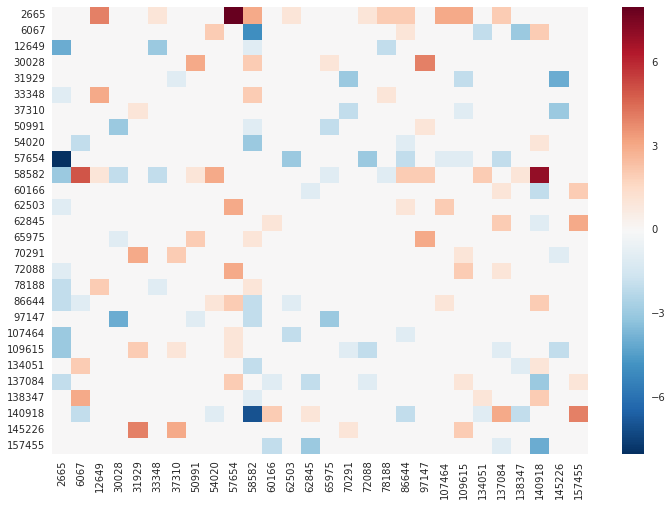

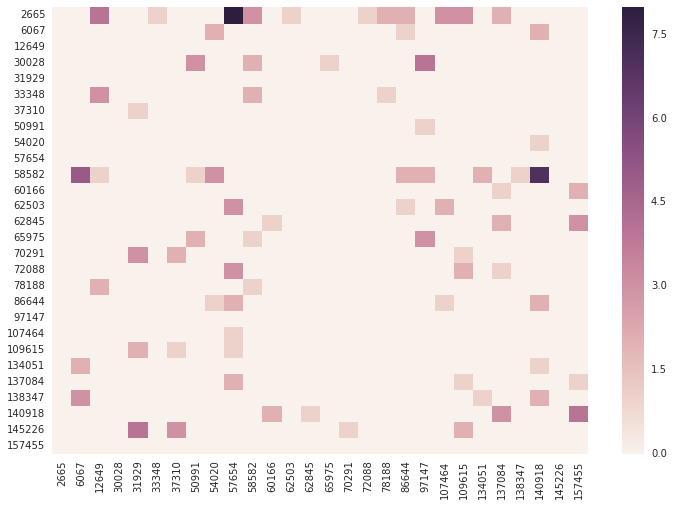

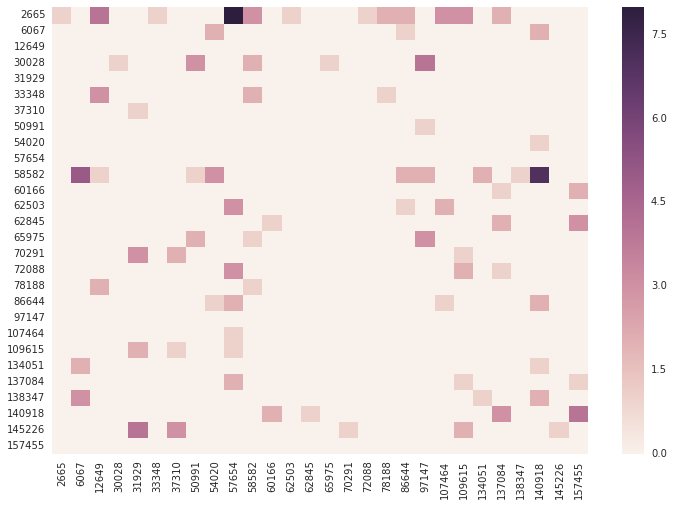

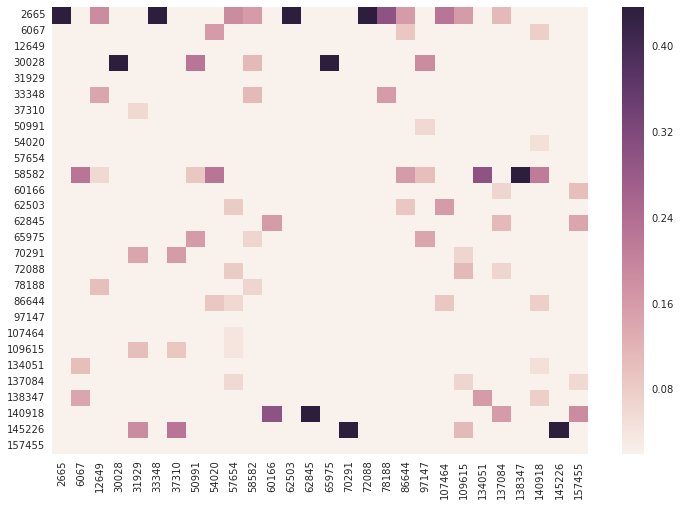

In [10]:

# Tests pour la constructions de la matrice de transition


t0 = time.time()

uniques = np.unique(ranks)

transit = np.zeros((len(uniques), len(uniques)))

"""
where_is = []
for i in range(len(uniques)):
    where_is.append(np.argwhere(ranks==uniques[i]))
    
comb = itertools.combinations(range(len(uniques)), 2)
for ij in comb:
    posi = where_is[ij[0]]
    posj = where_is[ij[1]]
    ranksi = np.sum(posi[np.in1d(posi[:,1], posj[:,1]),0])
    ranksj = np.sum(posj[np.in1d(posj[:,1], posi[:,1]),0])
    transit[ij[1],ij[0]] += ranksi-ranksj
    
    
"""

comb = itertools.combinations(range(len(uniques)), 2)
for ij in comb:
    #print ij
    for col in range(8):
        rank = ranks[:,col]
        if uniques[ij[0]] in rank and uniques[ij[1]] in rank:
            posi = np.argwhere(rank==uniques[ij[0]])[0][0]
            posj = np.argwhere(rank==uniques[ij[1]])[0][0]
            transit[ij[1],ij[0]] += posi-posj
            

transit = transit - transit.T

print 'time:', time.time() - t0
       
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

transit[transit<0.] = 0.
#transit[transit>0.] = 1.

fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

all_zero_columns_index = np.where(~transit.any(axis=0))[0]
transit[all_zero_columns_index, all_zero_columns_index] = 1.



fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

sums = np.sum(transit, axis=0)
transit = np.divide(transit, sums)

transit = transit + 5e-2
#for i in range(len(transit)):
#    probs = transit[:,i]
#    count = len(probs[probs!=0.])
#    probs[probs == 0] = 5e-1/float(count)
#    transit[:,i] = probs

sums = np.sum(transit, axis=0)
transit = np.divide(transit, sums)

transit[transit == np.nan] = 0.



fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(transit, xticklabels=uniques, yticklabels=uniques, ax=ax)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
number of iterations 3
predicted id: 128755 ,  target id: 142171

[128755  31575 142171   2891 127079  29070  48367  66593  47662   2506
 142160 106406 102055 159273  10063]


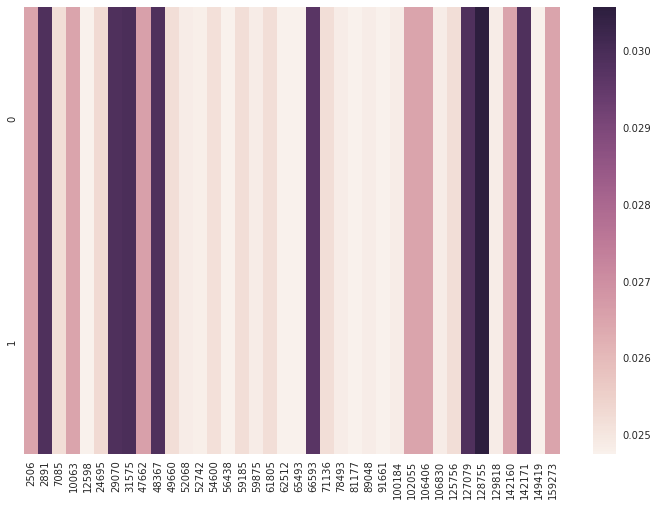

In [162]:
# test sur la boucle permettant d'obtenir l'état d'équilibre de la chaine de Markov

print np.sum(transit, axis=0)


tol = 1e-5
max_rounds= 1000

label_proba2 = np.ones(len(uniques))*1./len(uniques)

i = 0
diff = 1.
while diff >= tol and i <= max_rounds:
    label_proba1 = label_proba2
    label_proba2 = transit.dot(label_proba1)
    diff = np.linalg.norm(label_proba2 - label_proba1)
    i += 1
    
print 'number of iterations', i

label = label_proba2

# plotting the probability of each labels
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
sns.heatmap(np.vstack((label,label)), xticklabels=uniques, ax=ax)

max_label = uniques[np.argmax(label)]

print 'predicted id:', max_label, ',  target id:', target_id[0]
print
ind = np.argsort(-label)
print uniques[ind][:15]

# Test des 8 fonctions build_transition

### Données train

In [2]:
# loading data set
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

In [3]:
# building dictionnaries {Ids: labels}
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}
probes = { train['probeId'].ravel()[i]: train['probeLabel'].ravel()[i] for i in range(len(train['probeLabel']))}

In [4]:
# spliting the data set into train and test sets
train_ind, test_ind = train_test_indexes(len(train['probeId']),test_size=0.8, seed=1)

print train_ind.shape, test_ind.shape

# selecting training data
predId = train['resultsId'][train_ind, :, :60]
probeId = train['probeId'][train_ind, 0]
probeLabel = train['probeLabel'][train_ind, 0]

(9473,) (37890,)


In [ ]:
t0 = time.time()

# loop on the probes in the training set.
# The function find_label() from markov-chains.py is applied to each probe.
# For each probe, the function returns the Id of the highest item in the markov-chain meta ranking. 
num_cores = multiprocessing.cpu_count()
best_Ids = Parallel(n_jobs=num_cores - 2)(delayed(find_label)(predId[i,:,:], probeId[i], eps=3e-1, tol=1e-5, select_model=7) 
                                          for i in range(len(predId)))

chron = (time.time() - t0)/60.
print 'time:', (time.time() - t0)/60., 'min'

best_ids2 = best_Ids

# reformating the dictionnary
best_ids2 = {k.keys()[0]: k.values()[0] for k in best_ids2}

with open('result_model7_num60_eps3e-1_seed1_train.pkl', 'w') as fp:
    pickle.dump(best_ids2, fp)
    
mail.sendMail('maxime.kubryk@gmail.com','script markov-chain train 60 ended', 'ended in '+str(chron)+' min')

In [6]:
#with open('result_model7_num100_eps3e-1_seed42_train.pkl', 'rb') as fp:
#    best_ids2 = pickle.load(fp)

# getting the labels corresponding to the best Ids.
preds = np.asarray([int(gallery[best_ids2[i]]) for i in probeId.ravel()])

# getting the true label of the probes
probes_label = np.asarray([probes[i] for i in probeId.ravel()])

print len(preds), len(probes_label)
print preds
print probes_label

accuracy = np.mean(preds == probes_label)


print
print 'accuracy:', accuracy


9473 9473
[48061  5003 13731 ...,  7452 52052 37873]
[48061 13730 13731 ..., 37857 52052 37873]

accuracy: 0.975509342341


La cross validation est faite en changeant la valeur seed dans train_test_indexes.

eps= 1e-1

15 premiers rangs seulement

- model 0 
    - n_probes = 2369 : acc = 0.980582524272
    - seed = 42, n_probes = 9473 : acc = 0.973186952391
    - seed = 1, n_probes = 9473 : acc = 0.972236883775
- model 1
    - seed = 42, n_probes = 9473 : acc = 0.971603504698
    - seed = 1, n_probes = 9473 : acc = 0.97097012562
- model 2
    - seed = 42, n_probes = 9473 : acc = 0.972553573314
    - seed = 1, n_probes = 9473 : acc = 0.972553573314
- model 3
    - seed = 42, n_probes = 9473 : acc = 0.972870262852
    - seed = 1, n_probes = 9473 : acc = 0.972975826032
    - seed = 10, n_probes = 9473 : acc = 0.973820331468
- model 4
    - seed = 42, n_probes = 9473 : acc = 0.972659136493
    - seed = 1, n_probes = 9473 : acc = 0.972025757416
- model 5
    - seed = 42, n_probes = 9473 : acc = 0.969808930645
    - seed = 1, n_probes = 9473 : acc = 0.969914493825
- model 6
    - seed = 42, n_probes = 9473 : acc = 0.972236883775
    - seed = 1, n_probes = 9473 : acc = 0.972131320595
- model 7
    - seed = 42, n_probes = 9473 : acc = 0.972975826032
    - seed = 1, n_probes = 9473 : acc = 0.973081389211
    - seed = 10, n_probes = 9473 : acc = 0.973714768289
   

==> Le modèle 7 (build_transition8) a le meilleur score moyen

Avec le modèle 7

eps= 1e-2

- 50 premiers, seed = 42, n_probes = 9473 : acc = 0.974453710546
- 50 premiers, seed = 1, n_probes = 9473 : acc = 0.972553573314

eps= 1e-1

- 50 premiers, seed = 42, n_probes = 9473 : acc = 0.97582603188
- 50 premiers, seed = 1, n_probes = 9473 : acc = 0.975509342341
- 50 premiers, seed = 10, n_probes = 9473 : acc = 0.976142721419
 

eps= 3e-1

- 50 premiers, seed = 42, n_probes = 9473 : acc = 0.97593159506
- 50 premiers, seed = 1, n_probes = 9473 : acc = 0.97582603188
- 50 premiers, seed = 10, n_probes = 9473 : acc = 0.976248284598
- ==> 50 premiers, all test : acc = 0.975887

- 60 premiers, seed = 42, n_probes = 9473 : acc = 0.975509342341
- 60 premiers, seed = 1, n_probes = 9473 : acc = 
- 60 premiers, seed = 10, n_probes = 9473 : acc =


- 100 premiers, seed = 42, n_probes = 9473 : acc = 0.97593159506

eps= 5e-1

- 50 premiers, seed = 42, n_probes = 9473 : acc = 0.97593159506

### Application du modèle aux données test

In [28]:
test = io.loadmat('/home/max/projects/challengeMDI343/data/data_test.mat')

In [ ]:
predIds = test['resultsId'][:,:,:50]
probeIds = test['probeId'][:,0]

t0 = time.time()
num_cores = multiprocessing.cpu_count()
best_Ids = Parallel(n_jobs=num_cores - 2)(delayed(find_label)(predIds[i,:,:], probeIds[i], eps=3e-1, tol=1e-5, select_model=7) 
                                          for i in range(len(predIds)))

chron = (time.time()-t0)/60
print 'time:', (time.time()-t0)/60 , 'min'

best_Ids = {k.keys()[0]: k.values()[0] for k in best_Ids}

with open('result_model7_num50_eps3e-1_test.pkl', 'w') as fp:
    pickle.dump(best_Ids, fp)
    
mail.sendMail('maxime.kubryk@gmail.com','script markov-chain all test ended', 'ended in '+str(chron)+' min')

In [31]:
with open('result_model7_num50_eps3e-1_test.pkl', 'rb') as fp:
    best_Ids = pickle.load(fp)

gallery = {test['galleryId'].ravel()[i]: test['galleryLabel'].ravel()[i] for i in range(len(test['galleryLabel']))}
probeIds = test['probeId'][:,0]

preds = np.asarray([int(gallery[best_Ids[i]]) for i in probeIds.ravel()])

print preds

print preds.shape

np.savetxt('soumission11.txt', preds, fmt='%i')

[1008859 1008860 1008861 ..., 1044363 1044364 1044365]
(47361,)


# Test des modèles utilisant les scores

In [2]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}
probes = { train['probeId'].ravel()[i]: train['probeLabel'].ravel()[i] for i in range(len(train['probeLabel']))}

In [27]:
train_ind, test_ind = train_test_indexes(len(train['probeId']),test_size=0.8, seed=1)

print train_ind.shape, test_ind.shape

predId = train['resultsId'][train_ind, :, :50]
predScore = train['resultsScore'][train_ind, :, :50]
probeId = train['probeId'][train_ind, 0]
probeLabel = train['probeLabel'][train_ind, 0]

(9473,) (37890,)


In [28]:
t0 = time.time()
num_cores = multiprocessing.cpu_count()

best_Ids = Parallel(n_jobs=num_cores - 2)(
    delayed(find_label_with_scores)(predId[i,:,:], predScore[i,:,:], probeId[i], eps=4e-1, tol=1e-5, select_model=0
                       ) 
    for i in range(len(predId)))

chron = (time.time() - t0)/60.
print 'time:', (time.time() - t0)/60., 'min'

best_ids2 = best_Ids
best_ids2 = {k.keys()[0]: k.values()[0] for k in best_ids2}

time: 39.2073136171 min


In [29]:
preds = np.asarray([int(gallery[best_ids2[i]]) for i in probeId.ravel()])
probes_label = np.asarray([probes[i] for i in probeId.ravel()])

print len(preds), len(probes_label)
print preds
print probes_label

accuracy = np.mean(preds == probes_label)


print
print(accuracy)


9473 9473
[ 5003 13739 48096 ..., 37871 37874 37875]
[13730 13739 48096 ..., 37871 37874 37875]

0.97582603188


La cross validation est faite en changeant la valeur seed dans train_test_indexes.

- eps= 3e-1

  - 15 premiers rangs seulement

    - model 0 
      - seed = 42, n_probes = 9473 : acc = 0.974242584187
      - seed = 1, n_probes = 9473 : acc = 0.973609205109
    - model 1
      - seed = 42, n_probes = 9473 : acc = 0.974137021007
      - seed = 1, n_probes = 9473 : acc = 0.973292515571
      
  - 50 premiers rangs seulement
  
    - model 0 
      - seed = 42, n_probes = 9473 : acc = 0.97593159506
      - seed = 1, n_probes = 9473 : acc = 0.97582603188
    - model 1
      - seed = 42, n_probes = 9473 : acc = 0.976142721419
      - seed = 1, n_probes = 9473 : acc = 0.975298215982
      
- eps= 4e-1
 
  - 50 premiers rangs seulement
    - model 0
      - seed = 42, n_probes = 9473 : acc = 0.97582603188
      - seed = 1, n_probes = 9473 : acc = 0.97582603188
    - model 1 
      - seed = 42, n_probes = 9473 : acc = 0.976142721419
      - seed = 1, n_probes = 9473 : acc = 

# Test de l'aggrégation de plusieurs chaines de Markov

In [2]:
from markov_chains import random_rankings

In [3]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

In [118]:
#n = 52
#n = 67
#n = 85
#n=1047
n=67

ranks = train['resultsId'][n,:,:60]
ranks2 = ranks.T

print ranks2

label = train['probeLabel'][n,0]
target_id = train['galleryId'][[train['galleryLabel']==label]]

print
print 'target Id',target_id
print 'found label', find_label(ranks,0, eps=3e-1, tol=1e-5, select_model=7)

[[145226   2665   2665   2665 140918  58582  58582  30028]
 [ 70291  33348  62503  72088  62845   6067 138347  65975]
 [109615  78188  86644 137084  60166  86644 134051  58582]
 [ 37310  58582 107464 109615 137084  54020 140918  50991]
 [ 31929  12649  57654  57654 157455 140918   6067  97147]
 [ 73391 137084  87355  86644   6067  37310  30028 142931]
 [ 67084  87355  58582  50991  39733 157771  97855 140918]
 [126383  86644  78188 140918 115231 158799  60166   2665]
 [138118 107464  60166  58582 143143 138347  33348 106340]
 [113464 140918  62845  60166  80695  33348 130320  34712]
 [ 90081 137199 137084  56812 149483 145124  25668  86644]
 [154281  57654  86638  56405 117873  10477 107892  35293]
 [ 99496 145414  41375  47947 117593   3104  27157  12649]
 [  9598 114773  33348  67339  79097 152984 128438 114773]
 [  2665  65975 140918  87355   9587  91455 150057 104330]
 [ 41405 140925  72088  12649  34857  30028 110447 134005]
 [ 36440  56405  12649 104330  32193   2665 103512  7208

In [109]:
t0 = time.time()
rankings, probas = random_rankings(ranks, n_estimators=100, min_features=2, max_features=8, min_items=5, max_items=30, 
                            eps_min=0.001, eps_max=0.4, 
                            seed=10 ,n_jobs=None)

print 'time:', (time.time() - t0)/60.
#print rankings
print
#print probas

uniques, count = np.unique(rankings[0,:], return_counts=True)

print 'best Id:', int(uniques[np.argmax(count)])

"""
rankings = random_rankings(rankings.T, n_estimators=4, max_features=3, seed=4000)

print
print rankings

rankings = random_rankings(rankings.T, n_estimators=8, max_features=4, seed=8000)
print
print rankings

for i in range(10):
    rankings = random_rankings(rankings.T, n_estimators=8, max_features=4, seed=i)
    print
    print rankings
"""

time: 0.250324086348

best Id: 148751


'\nrankings = random_rankings(rankings.T, n_estimators=4, max_features=3, seed=4000)\n\nprint\nprint rankings\n\nrankings = random_rankings(rankings.T, n_estimators=8, max_features=4, seed=8000)\nprint\nprint rankings\n\nfor i in range(10):\n    rankings = random_rankings(rankings.T, n_estimators=8, max_features=4, seed=i)\n    print\n    print rankings\n'

# Test de la precision des random_rankings

In [26]:
from markov_chains import random_rankings

train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

probes = { train['probeId'].ravel()[i]: train['probeLabel'].ravel()[i] for i in range(len(train['probeLabel']))}
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}

In [41]:
train_ind, test_ind = train_test_indexes(len(train['probeId']), test_size=0.8, seed=42)

print train_ind.shape, test_ind.shape

predId = train['resultsId'][train_ind, :, :50]
probeId = train['probeId'][train_ind, 0]
probeLabel = train['probeLabel'][train_ind, 0]

(9473,) (37890,)


In [33]:
def compute_bestId(ranks, probeId, i):
    ranks = random_rankings(ranks, n_estimators=5, min_features=2, max_features=8, min_items=4, max_items=None, 
                            eps_min=0.001, eps_max=0.3, 
                            seed=10 ,n_jobs=None)
    uniques, count = np.unique(ranks[0,:], return_counts=True)
    bestId = uniques[np.argmax(count)]
    
    return {probeId: bestId}
    

n_jobs = multiprocessing.cpu_count()
        
t0 = time.time()
results = Parallel(n_jobs=n_jobs-2)(delayed(compute_bestId)(predId[i,:,:], probeId[i], i) for i in range(len(predId)))

chron = (time.time() - t0)/60.
print 'time:', chron

results = { k.keys()[0]: k.values()[0] for k in results }

with open('result_random_rankings_model7_num50_nest20_maxF8_seed42_njobsNone.pkl', 'w') as fp:
    pickle.dump(results, fp)
    
mail.sendMail('maxime.kubryk@gmail.com','script markov-chain ended', 'ended in '+str(chron)+'min')

KeyboardInterrupt: 

In [355]:
#

In [40]:
with open('result_random_rankings_model7_num15_nest20_maxF8_seed1_njobsNone.pkl', 'rb') as fp:
    results = pickle.load(fp)

print results

preds = np.asarray([int(gallery[results[i]]) for i in probeId ])

accuracy = np.mean(preds == probeLabel)

print
print 'accuracy', accuracy

{98304: 116730.0, 1: 158206.0, 5: 126884.0, 65551: 64253.0, 65553: 51907.0, 98326: 23879.0, 98335: 23640.0, 131104: 66414.0, 65570: 158434.0, 32803: 150949.0, 40: 26624.0, 98345: 15945.0, 98349: 106929.0, 32815: 93926.0, 53: 70841.0, 32825: 111026.0, 71007: 157709.0, 98369: 89835.0, 65603: 120783.0, 69: 102519.0, 72: 106966.0, 85: 3870.0, 32854: 150971.0, 90: 134542.0, 98397: 15388.0, 32869: 62737.0, 98417: 2240.0, 38249: 113952.0, 121: 145414.0, 65658: 148565.0, 123: 137263.0, 32893: 104944.0, 32899: 46130.0, 131205: 43616.0, 98438: 22075.0, 32907: 46709.0, 109250: 25362.0, 131221: 34949.0, 65686: 55124.0, 98461: 107435.0, 131231: 60615.0, 32928: 92549.0, 131233: 18794.0, 162: 38671.0, 65702: 124781.0, 87410: 94456.0, 32944: 147223.0, 32945: 45609.0, 98482: 18741.0, 32947: 27470.0, 131256: 119723.0, 186: 117507.0, 98493: 68518.0, 65726: 35429.0, 65732: 96153.0, 65733: 153537.0, 198: 57563.0, 98504: 72901.0, 32969: 32338.0, 131279: 35845.0, 98512: 93653.0, 131288: 885.0, 98522: 105403.

modele 7 uniquement, n_jobs=None


15 premiers de chaque rankings, n_probes=9473

- n_estimators=20, max_features=8, eps_min=0.1, eps_max=0.3
  - seed=42, acc= 0.973292515571
  - seed=1, acc= 0.972870262852
  - seed=10, acc=

Avec choix aléatoire du modèle entre 0 et 7

- test : random_rankings(ranks, n_estimators=500, max_features=3, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]

  train_test_indexes(test_size=0.9) --> 4737

  ==> accuracy = 0.969914493825

- random_rankings(ranks, n_estimators=10, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.99) --> 474
  
  ==> accuracy = 0.981012658228
  
- random_rankings(ranks, n_estimators=10, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.975738396624
  
- random_rankings(ranks, n_estimators=10, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.97) --> 1421
  
  ==> accuracy = 0.975369458128

- random_rankings(ranks, n_estimators=30, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.972573839662
  
- random_rankings(ranks, n_estimators=40, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.971518987342

n_estimators = 10, dépend beaucoup de la graine ==> un modèle doit être meilleur que les autres

In [52]:
def compute_bestId(ranks, probeId):
    for i in range(4):
        ranks = random_rankings(ranks, n_estimators=50, max_features=3, seed=10 ,n_jobs=10)
        ranks = ranks.T
        
    ranks = ranks.T
    uniques, count = np.unique(ranks[0,:], return_counts=True)
    bestId = uniques[np.argmax(count)]
    
    return {probeId: bestId}
    

n_jobs = multiprocessing.cpu_count()
        
t0 = time.time()
results = Parallel(n_jobs=n_jobs-4)(delayed(compute_bestId)(predId[i,:,:], probeId[i]) for i in range(len(predId)))

print 'time:', (time.time() - t0)/60.

results = { k.keys()[0]: k.values()[0] for k in results }

time: 1.64404379924


In [54]:
print results

preds = np.asarray([int(gallery[results[i]]) for i in probeId ])

accuracy = np.mean(preds == probeLabel)

print
print 'accuracy', accuracy

{63488: 101355.0, 132614: 82944.0, 85001: 90334.0, 157707: 120427.0, 120847: 27059.0, 151514: 115921.0, 104467: 28387.0, 48148: 34447.0, 146180: 153078.0, 5147: 150178.0, 99357: 158439.0, 40479: 16261.0, 114209: 14342.0, 81956: 8807.0, 46126: 70043.0, 58929: 138204.0, 28724: 34679.0, 122934: 115636.0, 105535: 141388.0, 6722: 83205.0, 54855: 90441.0, 76361: 12362.0, 143946: 79129.0, 79435: 105714.0, 66124: 121513.0, 112216: 89536.0, 56409: 65955.0, 48734: 77889.0, 156771: 81498.0, 31850: 112534.0, 7277: 150470.0, 91247: 128596.0, 71280: 127600.0, 70769: 146224.0, 72990: 72543.0, 133236: 63862.0, 130679: 136827.0, 58496: 122820.0, 66184: 148762.0, 58221: 158018.0, 69265: 60582.0, 30870: 67156.0, 95389: 1818.0, 86689: 44041.0, 83627: 125813.0, 30383: 155338.0, 56497: 158632.0, 17077: 113714.0, 47800: 34183.0, 78524: 10576.0, 90814: 852.0, 8384: 71979.0, 64715: 67146.0, 18120: 133655.0, 40649: 28922.0, 11467: 11508.0, 133328: 39210.0, 98009: 126332.0, 1243: 91773.0, 52090: 152615.0, 12001:

In [ ]:

bestId = []
for i in range(len(predId)):
    t0 = time.time()
    ranks = random_rankings(predId[i,:,:], n_estimators=500, max_features=3, seed=10 ,n_jobs=10)
    print i, 'time:', (time.time() - t0)/60.
    uniques, count = np.unique(ranks[0,:], return_counts=True)
    bestId.append(uniques[np.argmax(count)])
    
    
predLabel = np.asarray([gallery[Id] for Id in bestId])
accuracy = np.mean(predLabel == probeLabel)

print 'accuracy:', accuracy

0 time: 0.047626499335
1 time: 0.0424848516782
2 time: 0.0407281001409
3 time: 0.0426721016566
4 time: 0.0444009304047
5 time: 0.0443105856578
6 time: 0.039268553257
7 time: 0.0389854987462
8 time: 0.042581864198
9 time: 0.0407682816188
10 time: 0.0443589011828
11 time: 0.0424869497617
12 time: 0.040826634566
13 time: 0.044031616052
14 time: 0.0392276008924
15 time: 0.0423099517822
16 time: 0.0424614667892
17 time: 0.044063047568
18 time: 0.0426381031672
19 time: 0.0407710154851
20 time: 0.0442055344582
21 time: 0.0408784190814
22 time: 0.0409174164136
23 time: 0.0425877650579
24 time: 0.0414495666822
25 time: 0.0425382137299
26 time: 0.0441338857015
27 time: 0.0426707665126
28 time: 0.0407730976741
29 time: 0.0408513506254
30 time: 0.0426225145658
31 time: 0.0411207516988


Exception KeyboardInterrupt in <function remove at 0x7f8cb128de60> ignored


32 time: 0.0427542527517
33 time: 0.0425780812899
34 time: 0.0429438193639
35 time: 0.040701297919
36 time: 0.0407943487167
37 time: 0.0408687988917
38 time: 0.0460523843765
39 time: 0.0441219846408


# random_rankings avec model 0 seulement

- random_rankings(ranks, n_estimators=20, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.93) --> 3316
  
  ==> accuracy = 0.976477683957 (et meilleure qu'avec moins de probes)
  
- random_rankings(ranks, n_estimators=20, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  all training set
  
  ==> accuracy = 0.973586977176 (0.9736 sur leaderboard)
  
  

- random_rankings(ranks, n_estimators=40, max_features=8, seed=10 ,n_jobs=10)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.974683544304

In [3]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

probes = { train['probeId'].ravel()[i]: train['probeLabel'].ravel()[i] for i in range(len(train['probeLabel']))}
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}



In [54]:
train_ind, test_ind = train_test_indexes(len(train['probeId']), test_size=0.98)

print train_ind.shape, test_ind.shape

predId = train['resultsId'][train_ind, :, :15]
probeId = train['probeId'][train_ind, 0]

(948,) (46415,)


In [ ]:
predId = train['resultsId'][:, :, :15]
probeId = train['probeId'][:, 0]

def compute_bestId(ranks, probeId, i):
    ranks = random_rankings(ranks, n_estimators=40, max_features=8, eps_max=0.8, seed=10 ,n_jobs=None)
    uniques, count = np.unique(ranks[0,:], return_counts=True)
    bestId = uniques[np.argmax(count)]
    
    return {probeId: bestId}
    

n_jobs = multiprocessing.cpu_count()
        
t0 = time.time()
results = Parallel(n_jobs=n_jobs-2)(delayed(compute_bestId)(predId[i,:,:], probeId[i], i) for i in range(len(predId)))

chron = (time.time() - t0)/60.
print 'time:', chron

results = { k.keys()[0]: k.values()[0] for k in results }

with open('result_random_rankings_model0_n40_maxf8_njobsNone_train.pkl', 'w') as fp:
    pickle.dump(results, fp)
    
mail.sendMail('maxime.kubryk@gmail.com','script markov-chain all train ended', 'ended in '+str(chron)+' min')




In [3]:
with open('result_random_rankings_model0_n40_maxf8_njobsNone_train.pkl', 'rb') as fp:
    results = pickle.load(fp)

print results

train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}
probeId = train['probeId'][:, 0]
probeLabel = train['probeLabel'][:, 0]

preds = np.asarray([int(gallery[results[i]]) for i in probeId ])

accuracy = np.mean(preds == probeLabel)

print
print 'accuracy', accuracy

{0: 67575.0, 1: 158206.0, 2: 78027.0, 131077: 71012.0, 131079: 98873.0, 10: 146461.0, 14: 56700.0, 17: 89515.0, 18: 109361.0, 19: 158922.0, 24: 66408.0, 131100: 128785.0, 29: 111339.0, 5: 126884.0, 131104: 66414.0, 131106: 58876.0, 36: 113092.0, 38: 118525.0, 40: 26624.0, 131114: 37572.0, 53: 70841.0, 54: 136067.0, 131128: 41246.0, 131132: 66825.0, 131082: 28347.0, 62: 106062.0, 131135: 137118.0, 131136: 47185.0, 67: 46815.0, 69: 102519.0, 72: 106966.0, 73: 68158.0, 131147: 135743.0, 76: 14922.0, 131151: 95094.0, 131153: 28512.0, 131156: 60239.0, 85: 3870.0, 87: 121248.0, 90: 134542.0, 131164: 30974.0, 131165: 86096.0, 96: 35996.0, 131169: 31841.0, 131174: 99809.0, 65553: 51907.0, 107: 58629.0, 131183: 15079.0, 131185: 48965.0, 131187: 77194.0, 131191: 118.0, 121: 145414.0, 122: 20360.0, 123: 137263.0, 127: 152482.0, 131202: 18047.0, 131: 9005.0, 132: 53660.0, 131205: 43616.0, 134: 157109.0, 131208: 46323.0, 145: 136886.0, 146: 77672.0, 147: 62525.0, 131221: 34949.0, 131223: 118285.0, 

In [ ]:
# results on test data -----------------------------------------------------------------



train = io.loadmat('/home/max/projects/challengeMDI343/data/data_test.mat')

gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}

predId = train['resultsId'][:, :, :15]
probeId = train['probeId'][:, 0]

def compute_bestId(ranks, probeId, i):
    ranks = random_rankings(ranks, n_estimators=10, max_features=8, seed=10 ,n_jobs=None)
    uniques, count = np.unique(ranks[0,:], return_counts=True)
    bestId = uniques[np.argmax(count)]
    
    return {probeId: bestId}
    

n_jobs = multiprocessing.cpu_count()
        
t0 = time.time()
results = Parallel(n_jobs=n_jobs-2)(delayed(compute_bestId)(predId[i,:,:], probeId[i], i) for i in range(len(predId)))

chron = (time.time() - t0)/60.
print 'time:', chron

results = { k.keys()[0]: k.values()[0] for k in results }

with open('result_random_rankings_model0_n10_maxf8_njobsNone_test.pkl', 'w') as fp:
    pickle.dump(results, fp)
    
mail.sendMail('maxime.kubryk@gmail.com','script markov-chain all test ended', 'ended in '+str(chron)+' min')

In [50]:
with open('result_random_rankings_model0_n20_maxf8_test.pkl', 'rb') as fp:
    results = pickle.load(fp)
    
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_test.mat')
probeId = train['probeId'][:, 0]
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}

preds = np.asarray([int(gallery[results[i]]) for i in probeId ])

np.savetxt('soumission8.txt', preds, fmt='%i')

# random_rankings avec model 0 seulement , n_jobs=None

avec n_jobs != None tous les weak rankings sont les mêmes: chaque thread a la même graine pour np.random...

- random_rankings(ranks, n_estimators=10, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.973628691983 
  

- random_rankings(ranks, n_estimators=10, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :15]
  
  train_test_indexes(test_size=0.95) --> 2369
  
  ==> accuracy = 0.979316167159  (train_test_indexes seed=0: 0.978049810046)
  
- random_rankings(ranks, n_estimators=10, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :10]
  
  train_test_indexes(test_size=0.95) --> 2369
  
  ==> accuracy = 0.978049810046  (train_test_indexes seed=0: 0.978049810046 ???)
  
- random_rankings(ranks, n_estimators=10, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :7]
  
  train_test_indexes(test_size=0.95) --> 2369
  
  ==> accuracy = 0.974250738708  (train_test_indexes seed=0: 0.978471929084)
  
- random_rankings(ranks, n_estimators=10, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :15]
  
  all train set
  
  ==> accuracy = 0.973396955429
  
- random_rankings(ranks, n_estimators=20, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :15]
  
  all train set
  
  ==> accuracy = 0.973586977176
  
- random_rankings(ranks, n_estimators=40, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :15]
  
  all train set
  
  ==> accuracy = 0.973840339506
  
- random_rankings(ranks, n_estimators=20, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :10]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.974683544304 (train_test_indexes seed=0: 0.982067510549 ??? )
  
- random_rankings(ranks, n_estimators=10, max_features=8, max_eps=0.8, seed=10 ,n_jobs=None)

  predId = train['resultsId'][train_ind, :, :10]
  
  train_test_indexes(test_size=0.98) --> 948
  
  ==> accuracy = 0.972573839662 (train_test_indexes seed=0: 0.982067510549)

In [3]:
train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')

probes = { train['probeId'].ravel()[i]: train['probeLabel'].ravel()[i] for i in range(len(train['probeLabel']))}
gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}

In [35]:
train_ind, test_ind = train_test_indexes(len(train['probeId']), test_size=0.95, seed=0)

print train_ind.shape, test_ind.shape

predId = train['resultsId'][train_ind, :, :10]
probeId = train['probeId'][train_ind, 0]

(2369,) (44994,)


In [36]:
def compute_bestId(ranks, probeId, i):
    ranks = random_rankings(ranks, n_estimators=10, max_features=8, eps_max=0.8, seed=10 ,n_jobs=None)
    uniques, count = np.unique(ranks[0,:], return_counts=True)
    bestId = uniques[np.argmax(count)]
    
    return {probeId: bestId}
    

n_jobs = multiprocessing.cpu_count()
        
t0 = time.time()
results = Parallel(n_jobs=n_jobs-2)(delayed(compute_bestId)(predId[i,:,:], probeId[i], i) for i in range(len(predId)))

chron = (time.time() - t0)/60.
print 'time:', chron

results = { k.keys()[0]: k.values()[0] for k in results }

#with open('result_random_rankings_model0_n20_maxf8_train.pkl', 'w') as fp:
#    pickle.dump(results, fp)
    
#mail.sendMail('maxime.kubryk@gmail.com','script markov-chain all train ended', 'ended in '+str(chron)+' min')


time: 1.2450635155


In [37]:
#with open('result_random_rankings_model0_n20_maxf8_train.pkl', 'rb') as fp:
#    results = pickle.load(fp)

print results

#train = io.loadmat('/home/max/projects/challengeMDI343/data/data_train.mat')
#gallery = {train['galleryId'].ravel()[i]: train['galleryLabel'].ravel()[i] for i in range(len(train['galleryLabel']))}
#probeId = train['probeId'][:, 0]
probeLabel = train['probeLabel'][train_ind, 0]

preds = np.asarray([int(gallery[results[i]]) for i in probeId ])

accuracy = np.mean(preds == probeLabel)

print
print 'accuracy', accuracy

{24576: 44297.0, 32771: 70428.0, 131079: 98873.0, 155658: 130063.0, 40977: 109241.0, 106514: 91873.0, 81941: 8244.0, 155670: 85571.0, 71003: 40918.0, 32813: 3699.0, 90166: 14262.0, 73784: 13050.0, 125620: 49286.0, 114753: 120743.0, 69: 102519.0, 24646: 98962.0, 81: 8674.0, 8274: 90466.0, 57427: 151807.0, 106586: 119848.0, 122972: 34681.0, 16477: 8950.0, 90206: 141182.0, 8295: 27356.0, 96956: 118036.0, 152936: 44355.0, 49266: 36395.0, 41076: 32192.0, 142014: 3701.0, 114808: 56287.0, 82047: 121011.0, 123011: 76051.0, 98437: 144567.0, 123014: 47745.0, 24714: 17559.0, 123019: 8289.0, 32909: 95409.0, 145: 136886.0, 155795: 113701.0, 147607: 93758.0, 24729: 48800.0, 32929: 25739.0, 90275: 107648.0, 127004: 75099.0, 32938: 16907.0, 41131: 88616.0, 32940: 18581.0, 82094: 51872.0, 90291: 39579.0, 65718: 42782.0, 98489: 52164.0, 186: 117507.0, 65725: 40349.0, 131262: 117623.0, 16577: 156651.0, 139459: 111162.0, 127009: 60438.0, 90315: 48445.0, 139469: 75966.0, 8407: 10211.0, 65755: 86128.0, 1146